<a href=\"https://drive.google.com/file/d/1rdCfOBRMY80kbPoigL98mimz6k2cuCB_/view?usp=sharing"><img src=\"https://colab.research.google.com/assets/colab-badge.svg\" alt=\"Open In Colab\"/></a>

In [ ]:
#@title Installing libraries
!pip install -qq transformers jsonlines pytelegrambotapi

In [ ]:
#@title Setup & Config
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from collections import defaultdict, Counter

from sklearn.metrics import confusion_matrix, classification_report

import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8


from tqdm.notebook import tqdm
# from tqdm import tqdm 

RANDOM_SEED = 179
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
#@title Logger { run: "auto", vertical-output: true, display-mode: "form" }
token = "1282076787:AAEC3rYsSHh_livmutl0qDEemVhlhjWpWyI" #@param {type:"string"}
user_id =  182303123 #@param {type:"integer"}
combine = True #@param ["True", "False"] {type:"raw"}

import telebot
bot = telebot.TeleBot(token)
last_message = None

def logger(txt):
    global last_message
    while True:
        try:
            last_message_text = last_message.text if last_message != None else ''

            if type(txt) is tqdm:
                txt = txt.format_dict

                rate = txt["rate"] if txt["rate"] else 0
                remain = int((txt['total'] - txt['n']) / rate) if rate != 0 else 0

                txt = f"{txt['prefix']} - {int(txt['n'] / txt['total'] * 100)}%, {txt['n']}/{txt['total']} [{str(int(txt['elapsed']) // 60).rjust(2, '0')}:{str(int(txt['elapsed']) % 60).rjust(2, '0')}<{str(remain // 60).rjust(2, '0')}:{str(remain % 60).rjust(2, '0')}]"
                
                last_message_text = '\n'.join(last_message_text.split('\n')[:-1])

            if not last_message or not combine:
                last_message = bot.send_message(user_id, txt)
            else:
                last_message = bot.edit_message_text(chat_id=user_id,
                                      message_id=last_message.message_id,
                                      text=last_message_text + '\n' + txt)
            return
        except Exception as ex:
            print("Exception while logging:")
            print(ex)
            pass


# Download data

In [ ]:
!mkdir data/

!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/train.jsonl -o data/train.jsonl
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/val.jsonl -o data/val.jsonl
!curl https://raw.githubusercontent.com/AI-Front/NTI/main/semifinals/data/test.jsonl -o data/test.jsonl

mkdir: cannot create directory ‘data/’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2861k  100 2861k    0     0  12.4M      0 --:--:-- --:--:-- --:--:-- 12.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  553k  100  553k    0     0  5592k      0 --:--:-- --:--:-- --:--:-- 5592k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1698k  100 1698k    0     0  4628k      0 --:--:-- --:--:-- --:--:-- 4615k


# BertTokenizer Config

In [ ]:
#@title bert model name { vertical-output: true }
PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased" #@param {type:"string"}
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# BertTokenizer playground

In [ ]:
sample_txt = "(1) Но люди не могут существовать без природы, поэтому в парке стояли железобетонные скамейки — деревянные моментально ломали. (2) В парке бегали ребятишки, водилась шпана, которая развлекалась игрой в карты, пьянкой, драками, «иногда насмерть». (3) «Имали они тут и девок...» (4) Верховодил шпаной Артемка-мыло, с вспененной белой головой. (5) Людочка сколько ни пыталась усмирить лохмотья на буйной голове Артемки, ничего у неё не получалось. (6) Его «кудри, издали напоминавшие мыльную пену, изблизя оказались что липкие рожки из вокзальной столовой — сварили их, бросили комком в пустую тарелку, так они, слипшиеся, неподъёмно и лежали. (7) Да и не ради причёски приходил парень к Людочке. (8) Как только её руки становились занятыми ножницами и расчёской, Артемка начинал хватать её за разные места. (9) Людочка сначала увёртывалась от хватких рук Артемки, а когда не помогло, стукнула его машинкой по голове и пробила до крови, пришлось лить йод на голову «ухажористого человека». (10) Артемка заулюлюкал и со свистом стал ловить воздух. (11) С тех пор «домогания свои хулиганские прекратил», более того, шпане повелел Людочку не трогать."

In [ ]:
sample_txt = re.sub(r'\(\d+\)', '', sample_txt)
sample_txt

' Но люди не могут существовать без природы, поэтому в парке стояли железобетонные скамейки — деревянные моментально ломали.  В парке бегали ребятишки, водилась шпана, которая развлекалась игрой в карты, пьянкой, драками, «иногда насмерть».  «Имали они тут и девок...»  Верховодил шпаной Артемка-мыло, с вспененной белой головой.  Людочка сколько ни пыталась усмирить лохмотья на буйной голове Артемки, ничего у неё не получалось.  Его «кудри, издали напоминавшие мыльную пену, изблизя оказались что липкие рожки из вокзальной столовой — сварили их, бросили комком в пустую тарелку, так они, слипшиеся, неподъёмно и лежали.  Да и не ради причёски приходил парень к Людочке.  Как только её руки становились занятыми ножницами и расчёской, Артемка начинал хватать её за разные места.  Людочка сначала увёртывалась от хватких рук Артемки, а когда не помогло, стукнула его машинкой по голове и пробила до крови, пришлось лить йод на голову «ухажористого человека».  Артемка заулюлюкал и со свистом стал л

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence:  Но люди не могут существовать без природы, поэтому в парке стояли железобетонные скамейки — деревянные моментально ломали.  В парке бегали ребятишки, водилась шпана, которая развлекалась игрой в карты, пьянкой, драками, «иногда насмерть».  «Имали они тут и девок...»  Верховодил шпаной Артемка-мыло, с вспененной белой головой.  Людочка сколько ни пыталась усмирить лохмотья на буйной голове Артемки, ничего у неё не получалось.  Его «кудри, издали напоминавшие мыльную пену, изблизя оказались что липкие рожки из вокзальной столовой — сварили их, бросили комком в пустую тарелку, так они, слипшиеся, неподъёмно и лежали.  Да и не ради причёски приходил парень к Людочке.  Как только её руки становились занятыми ножницами и расчёской, Артемка начинал хватать её за разные места.  Людочка сначала увёртывалась от хватких рук Артемки, а когда не помогло, стукнула его машинкой по голове и пробила до крови, пришлось лить йод на голову «ухажористого человека».  Артемка заулюлюкал и со свис

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'но', 'люди', 'не', 'могут', 'су', '##щество', '##вать', 'без', 'природы', ',', 'поэтому', 'в', 'парк', '##е', 'сто', '##яли', 'же', '##ле', '##зо', '##бет', '##онные', 'с', '##кам', '##еи', '##ки', '[UNK]', 'дерев', '##ян', '##ные', 'момента', '##льно', 'ло', '##мали', '.', 'в', 'парк', '##е', 'б', '##ега', '##ли', 'р', '##еб', '##яти', '##шки', ',', 'води', '##лась', 'шп', '##ана', ',', 'которая', 'раз', '##в', '##лек', '##алась', 'игр', '##ои', 'в', 'карты', ',', 'п', '##ья', '##нко', '##и', ',', 'др', '##ака', '##ми', ',', '«', 'иногда', 'нас', '##мер', '##ть', '»', '.', '«', 'имали', 'они', 'тут', 'и', 'дев', '##ок', '.', '.', '.', '»', 'в', '##ерх', '##ово', '##дил', 'шп', '##ано', '##и', 'арт', '##ем', '##ка', '-', 'мы', '##ло', ',', 'с', 'в', '##сп', '##енен', '##нои', 'бел', '##ои', 'голов', '##ои', '.', 'л', '##ю', '##до', '##чка', 'с', '##колько', 'ни', 'п', '##ыта', '##лась', 'у', '##с', '##мир', '##ить', 'ло', '##х', '##мо', '##ть', '##я', 'на', 'бу', '##инои', '

# Dataset Class

In [ ]:
class QADataset(Dataset):
    """Question and answers dataset"""
    
    def __init__(self, path, tokenizer, max_len):
        """
        Args:
            path (string): Path to jsonl file
            tokenizer (BertTokenizer): bert tokenizer
            max_len (int): max len for bert input
        """
        self.path = path
        data = []
        with open(path, 'r') as json_file:
            json_list = list(json_file)
            for json_str in json_list:
                item = json.loads(json_str)
                text = item['passage']['text']
                questions = item['passage']['questions']
                for q in questions:
                    question = q['question']
                    ans = q['answers']
                    for a in ans:
                        data.append({"idx": a["idx"],
                                     "text": text,
                                     "question": question,
                                     "answer": a["text"],
                                     "data": f"[CLS] {question} [SEP] {a['text']} [SEP] {text}"})
                        data[-1]["data"] = re.sub(r'\(\d+\)', "", data[-1]["data"])
                        if 'label' in a:
                            data[-1]["label"] = a["label"]
        self.data = pd.DataFrame.from_dict(data).set_index("idx")
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx].data
        label = self.data.iloc[idx].label if "label" in self.data.columns else -1

        encoding = self.tokenizer.encode_plus(
            text[:self.max_len + 1],
            add_special_tokens=False,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )


        return {
            'texts': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }


# Data loader

In [ ]:
def create_data_loader(path, tokenizer, max_len, batch_size):
    ds = QADataset(
        path=path,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    ), len(ds)

Create dataloader

In [ ]:
BATCH_SIZE = 4
MAX_LEN = 505

train_data_loader, train_cnt = create_data_loader('data/train.jsonl', tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader, val_cnt = create_data_loader('data/val.jsonl', tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader, test_cnt = create_data_loader('data/test.jsonl', tokenizer, MAX_LEN, BATCH_SIZE)

Check if dataloader works

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([4, 505])
torch.Size([4, 505])
torch.Size([4])


# Model

In [ ]:
class QAClassifier(nn.Module):

    def __init__(self, dropout=0.3):
        super(QAClassifier, self).__init__()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=dropout)

        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.l1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size // 2)
        self.l2  = nn.Linear(self.bert.config.hidden_size // 2, self.bert.config.hidden_size // 4)
        self.l3  = nn.Linear(self.bert.config.hidden_size // 4, 1)

        self.proba = nn.Sigmoid()
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        output = self.relu(self.drop(self.l1(pooled_output)))
        output = self.relu(self.drop(self.l2(output)))
        output = self.relu(self.drop(self.l3(output)))

        output = self.proba(output)

        return output

In [ ]:
#@title Model params
dropout_prob = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}

In [ ]:
model = QAClassifier(dropout=dropout_prob)
model = model.to(device)

# Training model

In [ ]:
#@title Training functions
logger_step = 10 #@param {type:"slider", min:1, max:500, step:1}

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0
    cnt = 0
    
    pbar = tqdm(enumerate(data_loader), desc="training batch", total=len(data_loader))
    for num, d in pbar:
        if num % logger_step == 0:
            logger(pbar)

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        outputs = torch.reshape(outputs, (-1,))

        preds = (outputs >= .5).int()
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        cnt += len(preds)

        losses.append(loss.item())

        pbar.set_description(f"training batch (loss: {np.mean(losses):.2f}, acc: {(correct_predictions.double() / cnt * 100):.1f}%)")

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    logger(pbar)
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0
    cnt = 0

    with torch.no_grad():
        pbar = tqdm(enumerate(data_loader), desc="eval epoch", total=len(data_loader))
        for num, d in pbar:
            if num % logger_step == 0:
                logger(pbar)

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            outputs = torch.reshape(outputs, (-1,))

            preds = (outputs >= .5).int()

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            cnt += len(preds)

            pbar.set_description(f"training batch (loss: {np.mean(losses):.2f}, acc: {(correct_predictions.double() / cnt * 100):.1f}%)")

    logger(pbar)
    return correct_predictions.double() / n_examples, np.mean(losses)

## Setup

In [ ]:
#@title Training params
EPOCHS = 2 #@param {type:"slider", min:1, max:100, step:1}
learning_rate =  1e-3 #@param {type:"raw"}

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

## Train

In [ ]:
history = defaultdict(list)
best_accuracy = 0

pbar = tqdm(range(EPOCHS), desc="training epoch")

for epoch in pbar:
    print('-' * 10)
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    

    last_message = None
    logger(pbar)
    logger('=' * 25)
    logger('-')

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        train_cnt
    )

    logger(f'- Train loss: {train_loss}\n- Train accuracy: {train_acc}')
    logger('=' * 25)
    logger('-')

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        val_cnt
    )

    logger(f'- Val loss: {val_loss}\n- Val accuracy: {val_acc}')
    logger('=' * 25)

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        logger(f'saving model to best_model_state.bin')
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


----------
Epoch 1/2



Train loss 0.6935215355202535 accuracy 0.45037656903765694



Val   loss 0.6931471824645996 accuracy 0.4442953020134228

----------
Epoch 2/2



Train loss 0.6931471824645996 accuracy 0.45037656903765694



Val   loss 0.6931471824645996 accuracy 0.4442953020134228




## Save model

In [ ]:
torch.save(model.state_dict(), 'final_model_state.bin')

In [ ]:
from google.colab import files

files.download('final_model_state.bin')
files.download('best_model_state.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training plot

(0.0, 1.0)

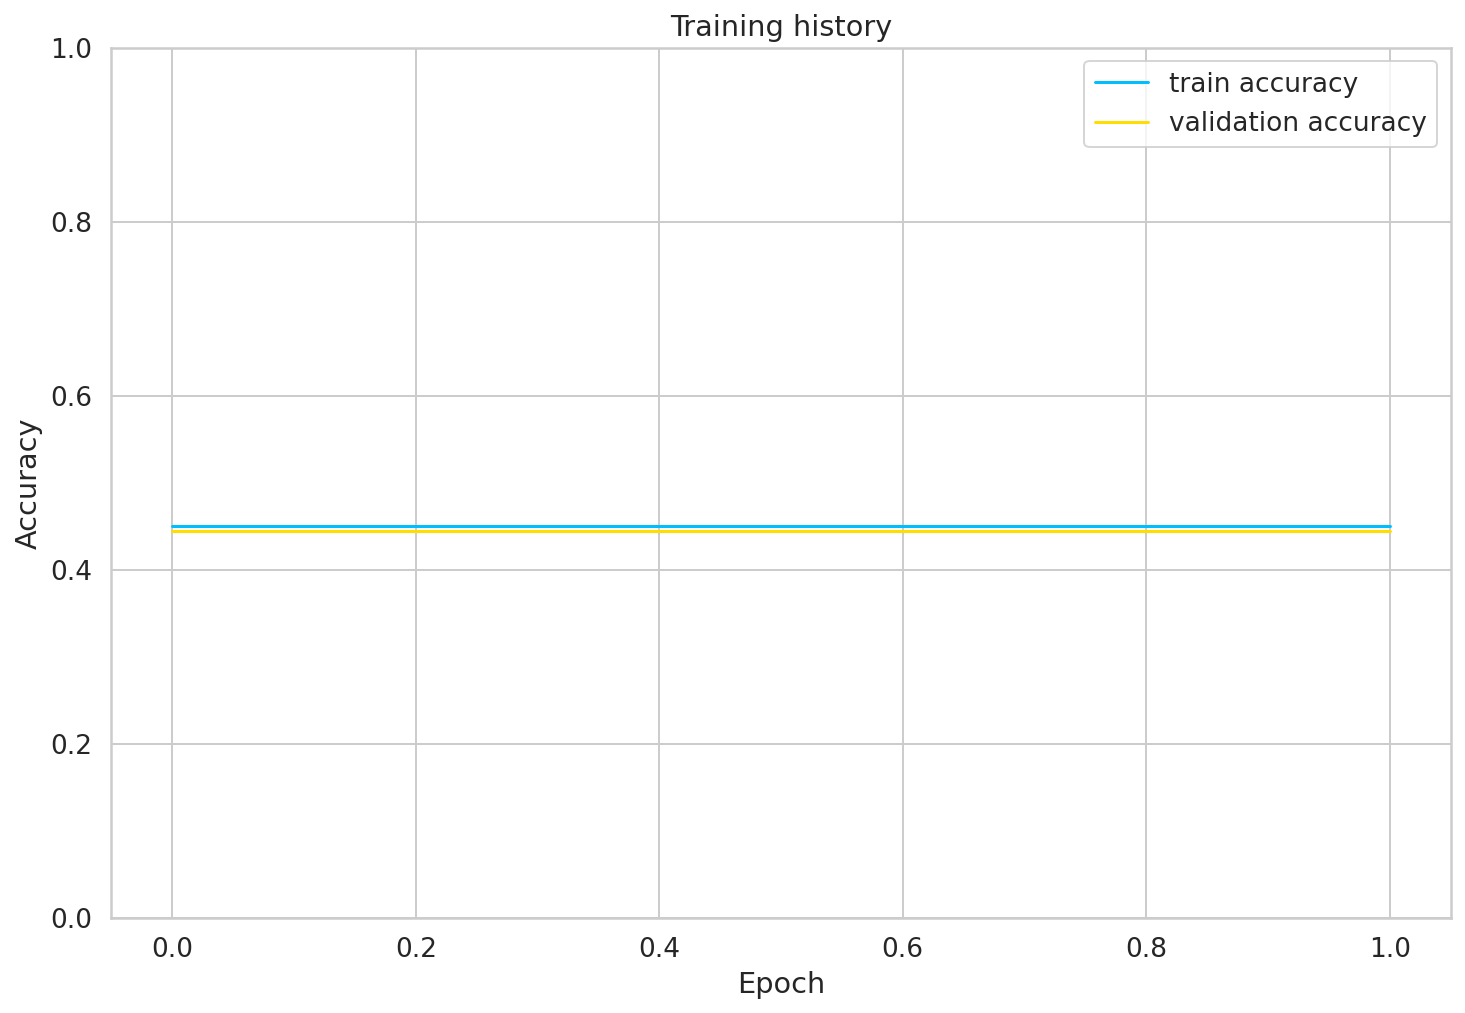

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# Predict

In [ ]:
#@title Predict function
def get_predictions(model, data_loader):
    global last_message
    last_message = None

    model = model.eval()
    
    real_texts = []
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        pbar = tqdm(enumerate(data_loader), desc="predicting", total=len(data_loader))
        for num, d in pbar:
            if num % logger_step == 0:
                logger(pbar)
            
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            outputs = torch.reshape(outputs, (-1,))
            preds = (outputs >= .5).int()

            real_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
        
        logger(pbar)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()

    return real_texts, predictions, prediction_probs

In [ ]:
y_texts, y_pred, y_pred_probs = get_predictions(model, test_data_loader)

In [ ]:
Counter(y_pred.tolist())

Counter({1: 7614})

In [ ]:
y_pred_probs

tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000])

In [ ]:
y_texts[:10]

['[CLS] О чем дневник Анны Франк? [SEP] Дневник об отметках Анны. [SEP] " Издательство Viking Press совместно с компанией TradeMobile выпустят мобильное приложение, посвященное Анне Франк, передает The Daily Telegraph.  Программа будет включать в себя фрагменты из дневника Анны, озвученные британской актрисой Хеленой Бонэм Картер.  Помимо этого, в приложение войдут фотографии и видеозаписи, документы из архива Фонда Анны Франк, план здания в Амстердаме, где Анна с семьей скрывались от нацистов, и факсимильные копии страниц дневника.  Приложение, которое получит название Anne Frank App, выйдет 18 октября.  Интерфейс программы будет англоязычным.  На каких платформах будет доступно Anne Frank App, не уточняется. Анна Франк родилась в Германии в 1929 году.  Когда в стране начались гонения на евреев, Анна с семьей перебрались в Нидерланды.  С 1942 года члены семьи Франк и еще несколько человек скрывались от нацистов в потайных комнатах дома в Амстердаме, который занимала компания отца Анны

## Make submit file

In [ ]:
def save_pred(filename, preds, model):
    with open('data/test.jsonl', 'r') as json_file:
        test = list(map(lambda x: json.loads(x), list(json_file)))
    ind = 0
    for i in range(len(test)):
        test[i]['passage'].pop("text")
        questions = test[i]['passage']['questions']
        for j in range(len(questions)):
            questions[j].pop("question")
            for k in range(len(questions[j]["answers"])):
                questions[j]["answers"][k] = {"idx": questions[j]["answers"][k]['idx'],
                                             "label": int(preds[ind])}
                ind += 1
    
    !mkdir submitions/
    
    with jsonlines.open("submitions/" + filename, 'w') as file:
        file.write_all(test)
    with open('submitions/info.txt', 'a') as file:
        file.write(f"- File: {filename}\nModel: {model}\n\n\n")

In [ ]:
file_name = f'{__import__("datetime").datetime.now()}.jsonl'

In [ ]:
save_pred(file_name, y_pred, str(model))

mkdir: cannot create directory ‘submitions/’: File exists


## Download submition

In [ ]:
files.download('submitions/' + file_name)
files.download('submitions/info.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
bot.send_document(user_id, open('submitions/' + file_name, 'rb'))
bot.send_document(user_id, open('submitions/info.txt', 'rb'))